# 实验二：卷积神经网络CNN超参数分析
姓名：王恩泰

学号：21114019

In [1]:
import os
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import torch.utils.data as Data
import torch.nn.functional as F
import torch.nn as nn
from PIL import Image

In [2]:
file_dir = ['./车辆分类数据集_small/car', './车辆分类数据集_small/bus', './车辆分类数据集_small/truck']

num_of_class = 3
# batch_size = batch_size
device = torch.device("cpu")

transform_compose = transforms.Compose( # 串联多个transform操作
    [transforms.Resize([100, 100]),  # 统一图形尺寸
    transforms.ToTensor(), # 转成tensor,ToTensor()能够把灰度范围从0-255变换到0-1之间
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # RGB 3个0.5,transform.Normalize()则把0-1变换到(-1,1), image=(image-mean)/std
])

train_tensor = None
test_tensor = None
train_label = []
test_label = []

# 逐个图片处理
for _dix, _dir in enumerate(file_dir):
    files = os.listdir(_dir) # 获取file list
    number_of_img = len(files) # img数量
    for index, img_file in enumerate(files):
        if img_file.endswith('.jpg'):
            img = Image.open(_dir+'/'+img_file)
            img = img.resize((100,100), Image.ANTIALIAS) # 变形
            img = np.array(img)/255
            img_tensor = torch.from_numpy(img)
            img_tensor = img_tensor.permute(2,1,0) # what means?
            if index < (0.8*number_of_img):
                if train_tensor is None:
                    print(img_tensor.shape)
                    train_tensor = img_tensor.unsqueeze(0)
                    print(train_tensor.shape)
                else:
                    train_tensor = torch.cat((train_tensor, img_tensor.unsqueeze(0)), dim=0)
                train_label.append(_dix)
            else:
                if test_tensor is None:
                    test_tensor = img_tensor.unsqueeze(0)
                else:
                    test_tensor = torch.cat((test_tensor, img_tensor.unsqueeze(0)), dim=0)
                test_label.append(_dix)

train_dataset = Data.TensorDataset(train_tensor, torch.LongTensor(train_label)) # train tensor 和 label tensor组合
test_dataset = Data.TensorDataset(test_tensor, torch.LongTensor(test_label))

# 这个dataloader同时存了X和y
# print(train_tensor.shape)
# print(test_tensor.shape) # (数量, 通道, H, W)


torch.Size([3, 100, 100])
torch.Size([1, 3, 100, 100])


In [3]:
class ConvModule(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, num_class): # 定义函数
        super(ConvModule, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size), # 输出为什么是32通道
            nn.BatchNorm2d(out_channels), # 2维的归一化
            nn.ReLU(inplace=True) # 可以覆盖之前的值
        )
        # 加个全连接层用于预测类别
        self.fc = nn.Linear(out_channels, num_of_class)

    def forward(self, X): # 使用上面定义的向前计算
        out = self.conv(X)
        local_kernel_size = out.shape[3]
        # print(local_kernel_size)       
        out = F.avg_pool2d(out, kernel_size=(local_kernel_size, local_kernel_size)) # 这个30的作用？平均数量为1*1
        out = out.squeeze() # 将张量batch*32*1*1 变为batch*32
        out = self.fc(out)
        return out

In [4]:
def train_epoch(net, data_loader, device): # 一个epoch的程序
    net.train() # 训练模式
    train_batch_num = len(data_loader)
    total_loss = 0
    correct = 0 # 正确分类样本个数
    sample_num = 0 # 样本总数

    for batch_idx, (x_train, y_train) in enumerate(data_loader):
        x_train = x_train.to(device).float()
        y_train = y_train.to(device).long() # 因为预测出来是long的
        
        optimizer.zero_grad()
        y_predict = net(x_train)
        # print(y_train)
        # print(y_predict)
        loss = criterion(y_predict, y_train)
        loss.backward()
        optimizer.step() # 更新参数

        total_loss += loss.item()
        prediction = torch.argmax(y_predict, 1)
        correct += (prediction == y_train).sum().item()
        sample_num += len(prediction)
    loss = total_loss / len(train_dataset)
    acc = correct / len(train_dataset)
    return loss, acc

def test_epoch(net, data_loader, device):
    net.eval()
    test_batch_num = len(data_loader)
    total_loss = 0
    correct = 0
    sample_num = 0
    with torch.no_grad():
        for batch_idx, (x_test, y_test) in enumerate(data_loader):
            x_test = x_test.to(device).float()
            y_test = y_test.to(device).long()
            y_predict = net(x_test)
            loss = criterion(y_predict, y_test)

            total_loss += loss.item()
            prediction = torch.argmax(y_predict, 1)
            correct += (prediction == y_test).sum().item()
            sample_num += len(prediction)
    loss = total_loss / len(test_dataset)
    acc = correct / len(test_dataset)
    return loss, acc

In [5]:
def cnn_train_test(lr, batch_size, output_channel, kernal_size):
    epochs = 20
    lr = lr
    batch_size = batch_size
    device = torch.device("cpu")

    train_loss_list = []
    train_acc_list = []
    test_loss_list = []
    test_acc_list = []

    train_data_loader = Data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    test_data_loader = Data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False)
    # 声明net model
    net = ConvModule(3, output_channel, kernal_size, 3).to(device)
    global criterion
    global optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    
    for epoch in range(epochs):
        train_loss, train_acc = train_epoch(net, train_data_loader, device)
        test_loss, test_acc = test_epoch(net, test_data_loader, device)
        train_loss_list.append(train_loss)
        train_acc_list.append(train_acc)
        test_loss_list.append(test_loss)
        test_acc_list.append(test_acc)
        
    print(f"epoch: {epoch}\t train_loss: {train_loss:.4f} \t" f"train_acc: {train_acc:.4f} \t"
        f"test_loss: {test_loss:.4f}\t test_acc: {test_acc:.4f}")        
    return train_loss_list, train_acc_list, test_loss_list, test_acc_list

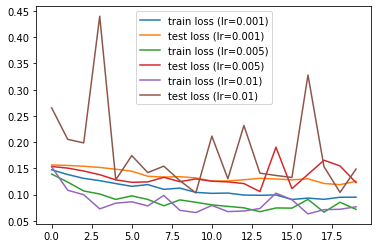

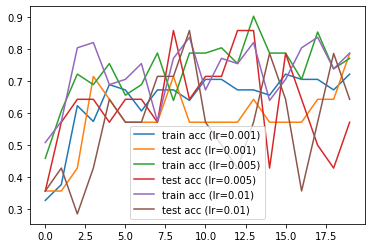

In [6]:
# lr = 0.001, batch_size = 8, out_channel = 32, kernal_size = 3
train_loss_list_lr_0_001, train_acc_list_lr_0_001, test_loss_list_lr_0_001, test_acc_list_lr_0_001 = \
    cnn_train_test(0.001, 8, 32, 3)

# lr = 0.05, batch_size = 8, out_channel = 32, kernal_size = 3
train_loss_list_lr_0_005, train_acc_list_lr_0_005, test_loss_list_lr_0_005, test_acc_list_lr_0_005 = \
    cnn_train_test(0.005, 8, 32, 3)

# lr = 0.1, batch_size = 8, out_channel = 32, kernal_size = 3
train_loss_list_lr_0_01, train_acc_list_lr_0_01, test_loss_list_lr_0_01, test_acc_list_lr_0_01 = \
    cnn_train_test(0.1, 8, 32, 3)


plt.plot(train_loss_list_lr_0_001, label='train loss (lr=0.001)')
plt.plot(test_loss_list_lr_0_001, label='test loss (lr=0.001)')
plt.plot(train_loss_list_lr_0_005, label='train loss (lr=0.005)')
plt.plot(test_loss_list_lr_0_005, label='test loss (lr=0.005)')
plt.plot(train_loss_list_lr_0_01, label='train loss (lr=0.01)')
plt.plot(test_loss_list_lr_0_01, label='test loss (lr=0.01)')
plt.legend() 
plt.show()
plt.plot(train_acc_list_lr_0_001, label='train acc (lr=0.001)')
plt.plot(test_acc_list_lr_0_001, label='test acc (lr=0.001)')     
plt.plot(train_acc_list_lr_0_005, label='train acc (lr=0.005)')
plt.plot(test_acc_list_lr_0_005, label='test acc (lr=0.005)')
plt.plot(train_acc_list_lr_0_01, label='train acc (lr=0.01)')
plt.plot(test_acc_list_lr_0_01, label='test acc (lr=0.01)')
plt.legend() 
plt.show()    

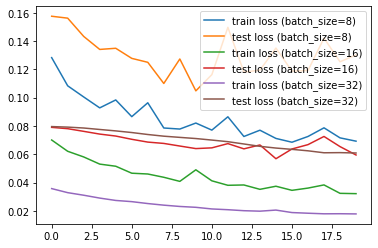

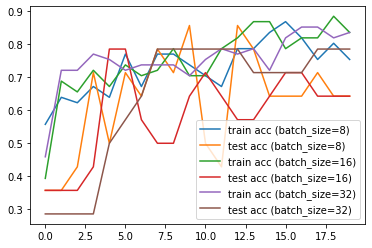

In [7]:
# lr = 0.05, batch_size = 8, out_channel = 32, kernal_size = 3
train_loss_list_batch_size_8, train_acc_list_batch_size_8, test_loss_list_batch_size_8, test_acc_list_batch_size_8 = \
    cnn_train_test(0.005, 8, 32, 3)

# lr = 0.05, batch_size = 16, out_channel = 32, kernal_size = 3
train_loss_list_batch_size_16, train_acc_list_batch_size_16, test_loss_list_batch_size_16, test_acc_list_batch_size_16 = \
    cnn_train_test(0.005, 16, 32, 3)    

# lr = 0.05, batch_size = 32, out_channel = 32, kernal_size = 3
train_loss_list_batch_size_32, train_acc_list_batch_size_32, test_loss_list_batch_size_32, test_acc_list_batch_size_32 = \
    cnn_train_test(0.005, 32, 32, 3)  

plt.plot(train_loss_list_batch_size_8, label='train loss (batch_size=8)')
plt.plot(test_loss_list_batch_size_8, label='test loss (batch_size=8)')
plt.plot(train_loss_list_batch_size_16, label='train loss (batch_size=16)')
plt.plot(test_loss_list_batch_size_16, label='test loss (batch_size=16)')
plt.plot(train_loss_list_batch_size_32, label='train loss (batch_size=32)')
plt.plot(test_loss_list_batch_size_32, label='test loss (batch_size=32)')
plt.legend() 
plt.show()
plt.plot(train_acc_list_batch_size_8, label='train acc (batch_size=8)')
plt.plot(test_acc_list_batch_size_8, label='test acc (batch_size=8)')
plt.plot(train_acc_list_batch_size_16, label='train acc (batch_size=16)')
plt.plot(test_acc_list_batch_size_16, label='test acc (batch_size=16)')
plt.plot(train_acc_list_batch_size_32, label='train acc (batch_size=32)')
plt.plot(test_acc_list_batch_size_32, label='test acc (batch_size=32)')
plt.legend() 
plt.show()   

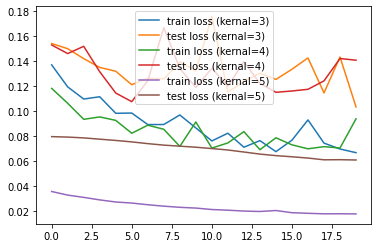

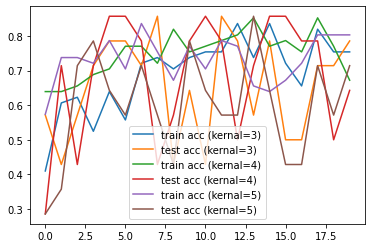

In [8]:
# lr = 0.05, batch_size = 8, out_channel = 32, kernal_size = 3
train_loss_list_kernal_3, train_acc_list_kernal_3, test_loss_list_kernal_3, test_acc_list_kernal_3 = \
    cnn_train_test(0.005, 8, 32, 3)

# lr = 0.05, batch_size = 16, out_channel = 32, kernal_size = 4
train_loss_list_kernal_4, train_acc_list_kernal_4, test_loss_list_kernal_4, test_acc_list_kernal_4 = \
    cnn_train_test(0.005, 8, 32, 4)    

# lr = 0.05, batch_size = 32, out_channel = 32, kernal_size = 5
train_loss_list_kernal_5, train_acc_list_kernal_5, test_loss_list_kernal_5, test_acc_list_kernal_5 = \
    cnn_train_test(0.005, 8, 32, 5)  

plt.plot(train_loss_list_kernal_3, label='train loss (kernal=3)')
plt.plot(test_loss_list_kernal_3, label='test loss (kernal=3)')
plt.plot(train_loss_list_kernal_4, label='train loss (kernal=4)')
plt.plot(test_loss_list_kernal_4, label='test loss (kernal=4)')
plt.plot(train_loss_list_batch_size_32, label='train loss (kernal=5)')
plt.plot(test_loss_list_batch_size_32, label='test loss (kernal=5)')
plt.legend() 
plt.show()
plt.plot(train_acc_list_kernal_3, label='train acc (kernal=3)')
plt.plot(test_acc_list_kernal_3, label='test acc (kernal=3)')
plt.plot(train_acc_list_kernal_4, label='train acc (kernal=4)')
plt.plot(test_acc_list_kernal_4, label='test acc (kernal=4)')
plt.plot(train_acc_list_kernal_5, label='train acc (kernal=5)')
plt.plot(test_acc_list_kernal_5, label='test acc (kernal=5)')
plt.legend() 
plt.show()   